In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# 1. Đọc dữ liệu
train_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\train.csv", parse_dates=['InvoiceDate'])
val_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\valid.csv", parse_dates=['InvoiceDate'])
test_df = pd.read_csv(r"D:\Năm 3 - HK2\Phân tích dữ liệu kinh doanh\IS403.P23.OnlineSalesData\Dataset\712\test.csv", parse_dates=['InvoiceDate'])

In [3]:
# 2. Tiền xử lý dữ liệu
def preprocess(df):
    df = df.copy()
    df['OrderTotal'] = (df['Quantity'] * df['UnitPrice'] * (1 - df['Discount']) + df['ShippingCost'])

    df = df[['InvoiceDate', 'OrderTotal']]
    df = df.set_index('InvoiceDate').resample('D').sum().reset_index()

    df['dayofweek'] = df['InvoiceDate'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['month'] = df['InvoiceDate'].dt.month
    df['day'] = df['InvoiceDate'].dt.day
    df['year'] = df['InvoiceDate'].dt.year

    df['lag1'] = df['OrderTotal'].shift(1)
    df['lag7'] = df['OrderTotal'].shift(7)
    df['lag14'] = df['OrderTotal'].shift(14)

    df['rolling_mean_7'] = df['OrderTotal'].rolling(window=7).mean()
    df['rolling_std_7'] = df['OrderTotal'].rolling(window=7).std()
    
    df.dropna(inplace=True)
    return df

train = preprocess(train_df)
valid = preprocess(val_df)
test = preprocess(test_df)

features = ['dayofweek', 'is_weekend', 'month', 'day', 'year',
            'lag1', 'lag7', 'lag14', 'rolling_mean_7', 'rolling_std_7']

X_train, y_train = train[features], train['OrderTotal']
X_valid, y_valid = valid[features], valid['OrderTotal']
X_test, y_test = test[features], test['OrderTotal']

In [4]:
# 3. Chuẩn hóa dữ liệu 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled  = scaler.transform(X_test)


In [5]:
# 4. Huấn luyện mô hình
svm_model = SVR(kernel='rbf', C=100, epsilon=0.1)
svm_model.fit(X_train_scaled, y_train)

SVR(C=100)

In [6]:
# 5. Dự đoán test
y_pred = svm_model.predict(X_test_scaled)

In [7]:
# 6. Dự báo tương lai đến hết 2026
future_dates = pd.date_range(start=test['InvoiceDate'].max() + pd.Timedelta(days=1), end='2026-12-31', freq='D')
last_known = test.copy()

future_forecast = []

for date in future_dates:
    row = {
        'InvoiceDate': date,
        'dayofweek': date.dayofweek,
        'is_weekend': int(date.dayofweek in [5, 6]),
        'month': date.month,
        'day': date.day,
        'year': date.year
    }

    for lag in [1, 7, 14]:
        lag_date = date - pd.Timedelta(days=lag)
        lag_value = last_known.loc[last_known['InvoiceDate'] == lag_date, 'OrderTotal']
        row[f'lag{lag}'] = lag_value.values[0] if not lag_value.empty else np.nan

    recent = last_known[last_known['InvoiceDate'] < date].sort_values('InvoiceDate').tail(7)
    row['rolling_mean_7'] = recent['OrderTotal'].mean() if len(recent) >= 1 else np.nan
    row['rolling_std_7'] = recent['OrderTotal'].std() if len(recent) >= 1 else np.nan

    if any(pd.isna(val) for val in row.values()):
        continue

    X_future = pd.DataFrame([row])[features]
    X_future_scaled = scaler.transform(X_future)
    pred = svm_model.predict(X_future_scaled)[0]

    row['PredictedOrderTotal'] = pred
    last_known = pd.concat([last_known, pd.DataFrame([{'InvoiceDate': date, 'OrderTotal': pred}])], ignore_index=True)
    future_forecast.append(row)

future_forecast = pd.DataFrame(future_forecast)

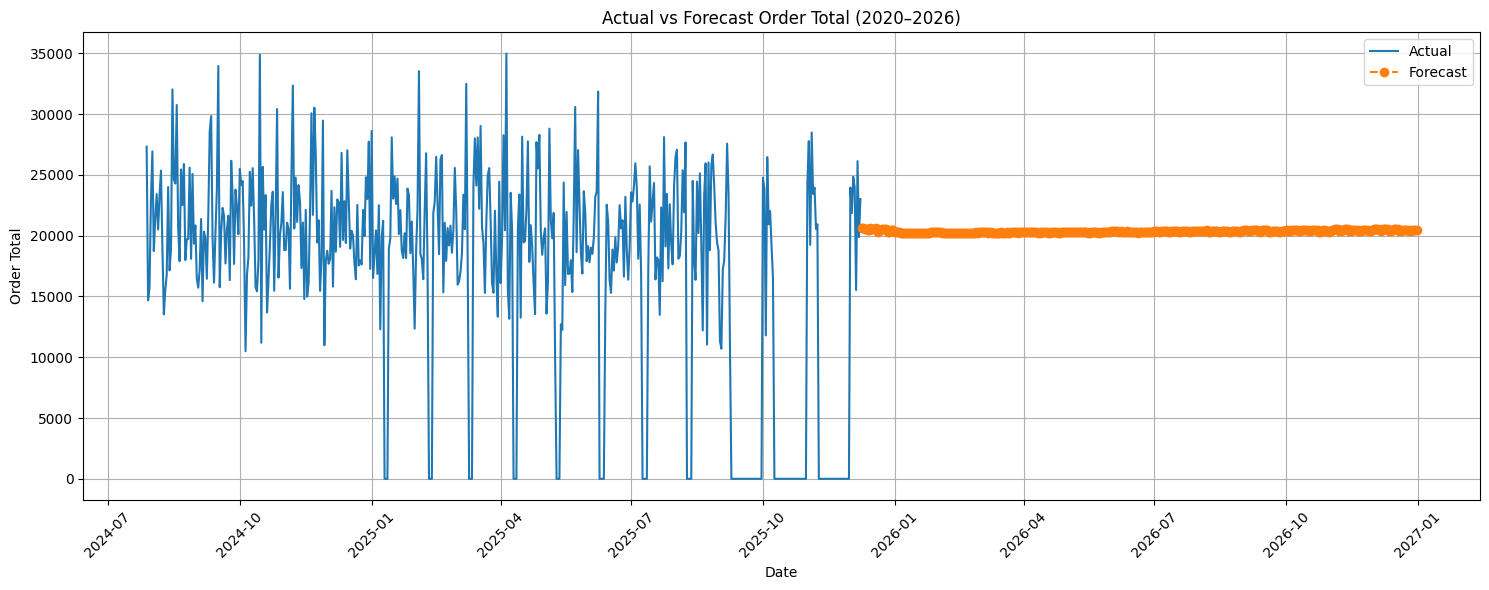

In [8]:
# 7. Trực quan hóa Actual vs Forecast
actual_df = test[['InvoiceDate', 'OrderTotal']].rename(columns={'OrderTotal': 'Value'})
actual_df['Type'] = 'Actual'

forecast_df = future_forecast[['InvoiceDate', 'PredictedOrderTotal']].rename(columns={'PredictedOrderTotal': 'Value'})
forecast_df['Type'] = 'Forecast'

full_df = pd.concat([actual_df, forecast_df], ignore_index=True)

plt.figure(figsize=(15, 6))
for label, df_part in full_df.groupby('Type'):
    plt.plot(df_part['InvoiceDate'], df_part['Value'], label=label,
             linestyle='--' if label == 'Forecast' else '-', marker='o' if label == 'Forecast' else '')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))

plt.xticks(rotation=45)
plt.title('Actual vs Forecast Order Total (2020–2026)')
plt.xlabel('Date')
plt.ylabel('Order Total')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
# 8. Đánh giá
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:,.2f}")
print(f"MSE: {mse:,.2f}")
print(f"R2 Score: {r2:.4f}")

MAE: 6,677.89
MSE: 94,419,624.32
R2 Score: -0.1382
